<font size="8"> **Calculating bottom bathymetry from GEBCO-based data** </font>  


# Loading modules

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

In [5]:
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
#Spatial analysis
from xrspatial import slope
import rioxarray

# Accessing ACCESS-OM2-01 outputs
We will use the latitude and longitude values from the `area_t` output to correct the bathymetry data derived from GEBCO.

In [3]:
#Starting cookbook session to search for area data
session = cc.database.create_session()
#Load area data for a single month
area = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'area_t', session, n = 1)
#Check results
area

<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)>
dask.array<open_dataset-a3dcdada652a62056900287409cd22dcarea_t, shape=(2700, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2022-04-27
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

# Loading GEBCO bathymetry file

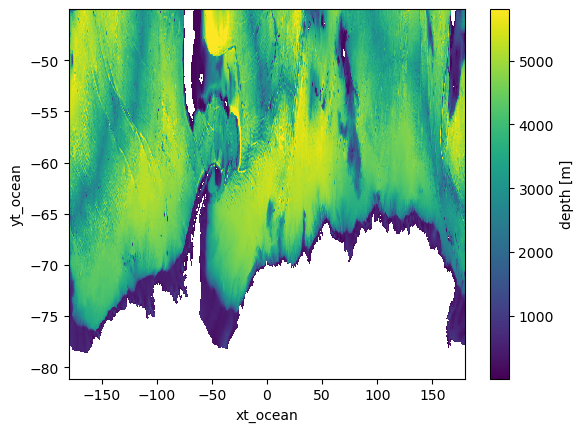

In [4]:
#Loading data
bathy = xr.open_dataarray('/g/data/ik11/inputs/access-om2/input_20201102/mom_01deg/topog.nc')

#Assigning correct coordinates
bathy.coords['xx'] = area['xt_ocean'].values
bathy.coords['yy'] = area['yt_ocean'].values
#Rename coordinate variables so they match ocean data
bathy = bathy.rename(({'xx':'xt_ocean', 'yy':'yt_ocean'})).sel(yt_ocean = slice(-90, -45))
bathy = uf.corrlong(bathy)
bathy.plot()

## Saving results as netcdf

In [6]:
base_folder = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'
bathy.to_netcdf(os.path.join(base_folder, 'bathy_GEBCO_2D.nc'))

## Saving results as tiff

In [9]:
#Adding CRS (WGS84)
bathy.rio.write_crs('epsg:4326', inplace = True)
#Changing latitude and longitude names
bathy = bathy.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
#Saving output
bathy.rio.to_raster(os.path.join(base_folder, 'Rasters_tiff/bathy_GEBCO_2D.tif'))

# Calculating bottom slope
We will use the `xarray_spatial` library to calculate the bottom slope (in degrees) from the 2D bathymetry data. 

In [10]:
bathy_slope = slope(bathy)

## Adding some metadata
Recording units and variable name in the data array.

In [11]:
bathy_slope = bathy_slope.assign_attrs({'name': 'slope',
                                        'units': 'degrees'})
bathy_slope

<xarray.DataArray 'slope' (y: 740, x: 3600)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan, 89.980934, 89.97815 , ..., 89.95448 , 89.82254 ,
              nan],
       [      nan, 89.98764 , 89.98772 , ..., 89.84879 , 89.967476,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * x            (x) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
  * y            (y) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
    spatial_ref  int64 0
Attributes:
    long_name:                   depth
    units:                       degrees
    minimum_depth:               10.43281
    minimum_levels:              7
    min_thick:                   1.0
    min_frac:                    0.2
    nonadvective_cells_removed:  yes
    lakes_removed:               yes
    name:                        slope

## Plotting results

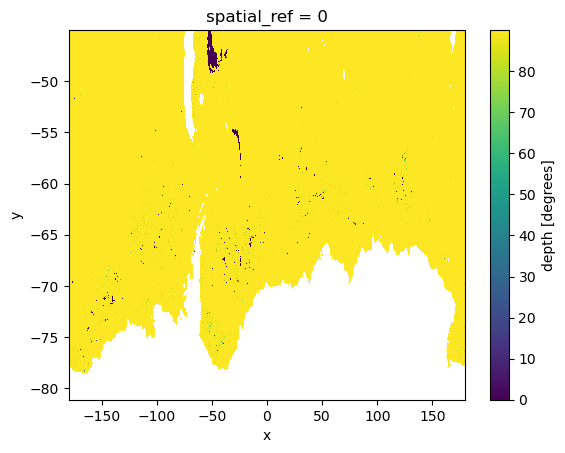

In [12]:
bathy_slope.plot()

## Saving results as netcdf

In [25]:
bathy_slope.to_netcdf(os.path.join(base_folder, 'bathy_slope_GEBCO_2D.nc'))

## Saving results as tiff

In [14]:
#Adding CRS (WGS84)
bathy_slope.rio.write_crs('epsg:4326', inplace = True)
#Saving output
bathy_slope.rio.to_raster(os.path.join(base_folder, 'Rasters_tiff/bathy_slope_GEBCO_2D.tif'))

# Comparing results to slope derived from model grid

In [15]:
bathy_mod = xr.open_dataarray(os.path.join(base_folder, 'bathy_slope_2D.nc'))
bathy_mod

<xarray.DataArray 'slope' (yt_ocean: 740, xt_ocean: 3600)>
[2664000 values with dtype=float64]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    name:     slope
    units:    degrees

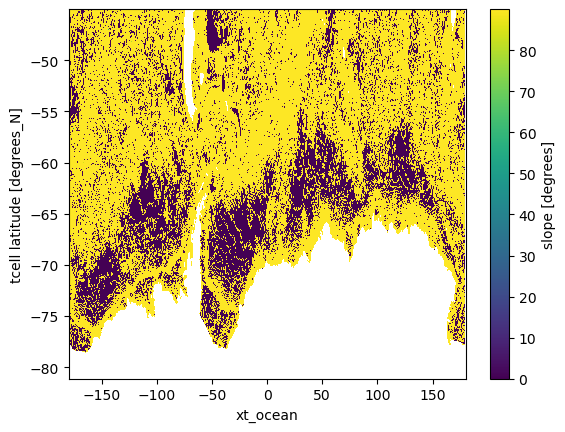

In [17]:
bathy_mod.plot()

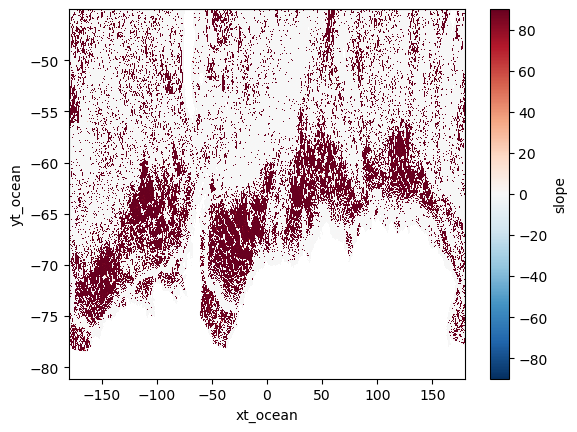

In [24]:
(bathy_slope-bathy_mod).plot()